# Lotka-Volterra

$$
\begin{cases}
x'=\alpha x-\beta xy\\
y'=\delta xy -\gamma y
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
import scienceplots
plt.style.use(["science", "notebook", "grid"])

In [2]:
def lotka_volterra(t, x, params = [2/3, 4/3, 1, 1]):
    """ 
    Lotka-Volterra data

    Args:
        t (array): Time
        x (array): Data
        params (array, optional): parameters alpha, beta, gamma, delta. Defaults to [2/3, 4/3, 1, 1]

    Returns:
        array: Lotka-Volterra data
    """
    assert len(params) == 4
    return [params[0] * x[0] - params[1] * x[0] * x[1], params[2] * x[0] * x[1] - params[3] * x[1]]

In [3]:
print(2/3, 4/3, 1, 1)

0.6666666666666666 1.3333333333333333 1 1


# Clean

In [4]:
x0 = [1, 2]
delta_t = 0.01
t = np.arange(0, 20, delta_t)
np.random.seed(42)
x_train = solve_ivp(lotka_volterra, (t[0], t[-1]), x0, t_eval=t, rtol = 1e-12, method = "LSODA", atol = 1e-12).y.T
x_dot = np.array([lotka_volterra(0, x_train[t]) for t in range(t.size)])
x = x_train[:, 0]
y = x_train[:, 1]

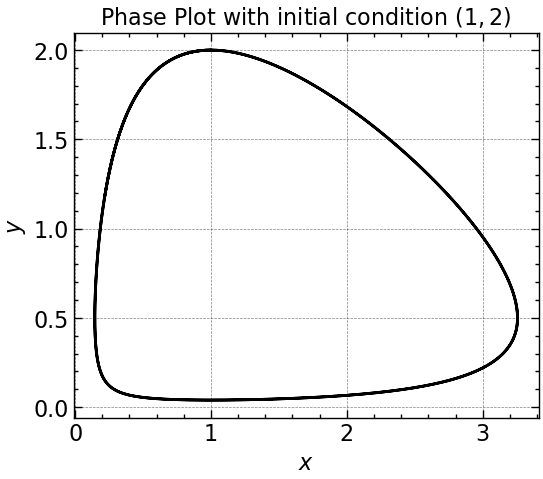

In [5]:
plt.figure(figsize=(6, 5))
plt.plot(x, y, "k")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Phase Plot with initial condition $(1,2)$")
plt.show()

In [6]:
opt = ps.STLSQ(threshold=0.05)
lib = ps.PolynomialLibrary(degree=3)
diff = ps.FiniteDifference() 
model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff, feature_names=["x", "y"])
model.fit(x_train, t, x_dot)
model.print(precision = 5)

(x)' = 0.66667 x + -1.33333 x y
(y)' = -1.00000 y + 1.00000 x y


In [7]:
model.score(x_train, t, x_dot)

1.0

In [8]:
x_train_sim = model.simulate(x0, t)
x_sim = x_train_sim[:, 0]
y_sim = x_train_sim[:, 1]

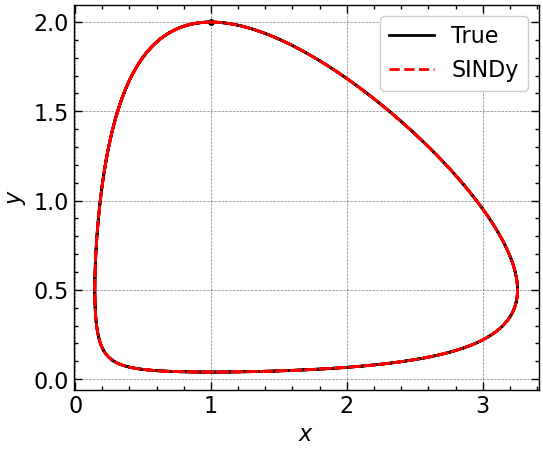

In [9]:
plt.figure(figsize=(6, 5))
plt.plot(x, y, "k", label = "True")
plt.plot(x_sim, y_sim, "r--", label = "SINDy")
plt.scatter(x0[0], x0[1], c = "k", s = 15)
plt.xlabel("$x$")
plt.ylabel("$y$")
# plt.title("Clean")
plt.legend()
plt.show()

In [10]:
def plot_xyz(sim_x, sim_y, x=x, y=y, title="Clean Data"):
    """
    Plots dynamics of in x,y

    Args:
        sim_x (_type_): Simulated data for x
        sim_y (_type_): Simulated data for y
        x: True data for x. Defaults to x_data.
        y: True data for y. Defaults to y_data.
        title: part of text to put in the title of the plot
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    axes[0].plot(t, x, label='True', c = "k")
    axes[0].plot(t, sim_x, "r--", label='SINDy')
    axes[0].set_ylabel('$x$', fontsize = 15)
    axes[0].legend(loc = "lower right", prop={'size': 10})
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_tick_params(labelsize=10)

    axes[1].plot(t, y[:], c = "k")
    axes[1].plot(t, sim_y, "r--")
    axes[1].set_xlabel('$t$', fontsize = 15)
    axes[1].set_ylabel('$y$', fontsize = 15)
    axes[1].xaxis.set_tick_params(labelsize=10)
    axes[1].yaxis.set_tick_params(labelsize=10)
    
    
    plt.suptitle(f"True vs SINDy in $(x,y)$ for $t\in[0,{int(len(t)*delta_t)}]$, {title}")
    plt.tight_layout()
    plt.show()

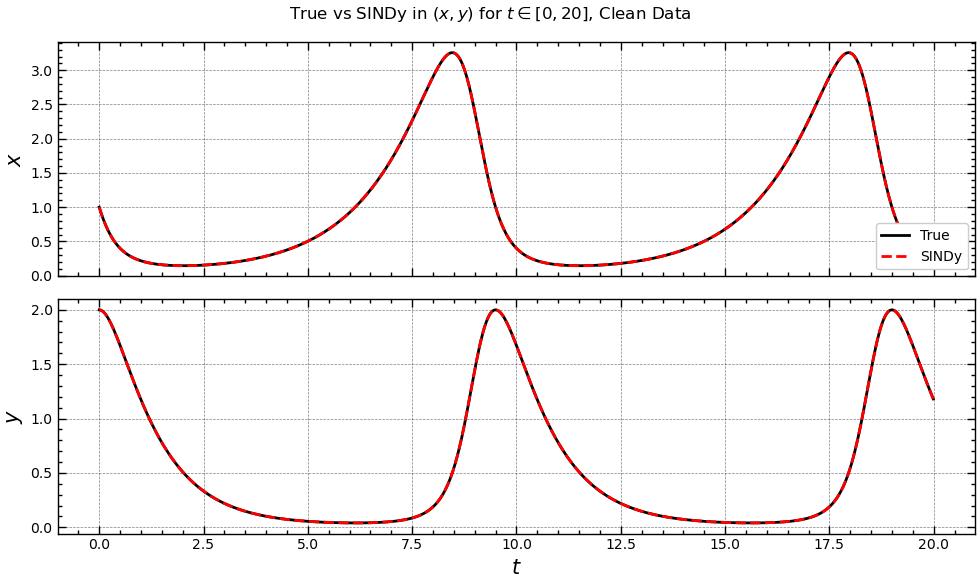

In [11]:
plot_xyz(x_sim, y_sim, x, y)

Perfect.

# Noise $\eta=0.05$ in $\mathbf{X}$ and $\mathbf{X}'$

This amount of noise seems reasonable and realistic.

In [12]:
np.random.seed(42)
noise = np.random.normal(loc=0, scale = 0.05, size=x_train.shape) # N(0,0.05^2)
x_train_noise = x_train + noise
x_noise = x_train_noise[:, 0]
y_noise = x_train_noise[:, 1]

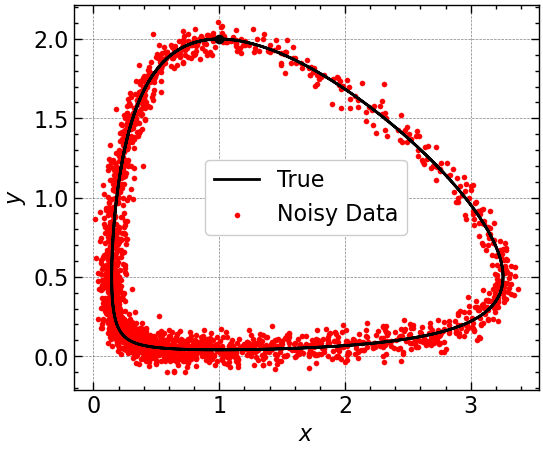

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(x, y, "k", label = "True")
plt.scatter(x_noise, y_noise, c = "r", s = 15, linewidths= 0.1, label = "Noisy Data")
plt.scatter(x0[0], x0[1], c = "k")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
# plt.title("Phase Plot, Initial Condition $(1,2)$")
plt.show()

In [24]:
opt = ps.SR3(threshold=0.01)
lib = ps.PolynomialLibrary(degree=2)
diff = ps.SmoothedFiniteDifference()
x0 = [1, 2]
model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff, feature_names=["x", "y"])
x_dot_noise = x_dot + noise
model.fit(x_train_noise, t, x_dot_noise)
model.print(precision=5)

(x)' = -0.04906 1 + 0.74180 x + 0.15500 y + -0.02651 x^2 + -1.30833 x y + -0.09960 y^2
(y)' = -0.01167 1 + 0.00577 x + -0.95377 y + 0.98211 x y + -0.01179 y^2


In [15]:
x_train_noise_sim = model.simulate(x0, t)
x_noise_sim = x_train_noise_sim[:, 0]
y_noise_sim = x_train_noise_sim[:, 1]

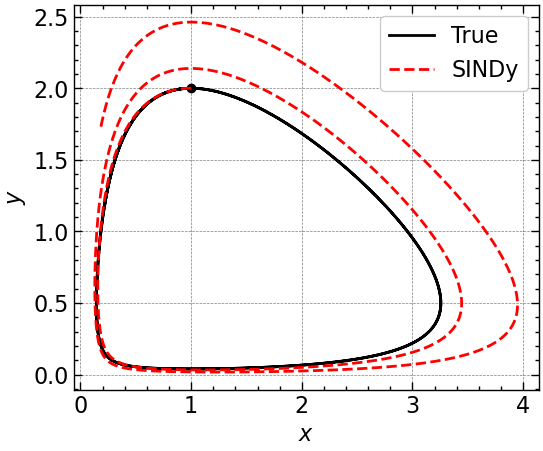

In [16]:
plt.figure(figsize=(6, 5))
plt.plot(x, y, "k", label = "True")
plt.plot(x_noise_sim, y_noise_sim, "r--", label = "SINDy")
plt.scatter(x0[0], x0[1], c = "k")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
# plt.title("Phase Plot with initial condition $(1,2)$")
plt.show()

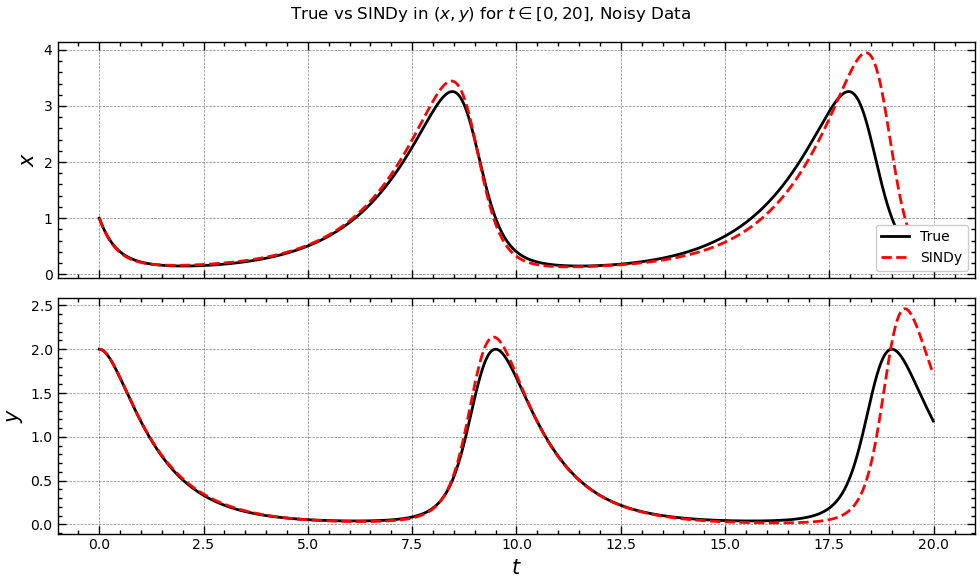

In [17]:
plot_xyz(x_noise_sim, y_noise_sim, x, y, title= "Noisy Data")